# Schrodinger equation
---

$$
\begin{aligned}
\varepsilon u_t - i\frac{\epsilon^2}{2}\Delta u + i V(x)u = 0, \ t \in \mathbb{R}, x\in \mathbb{R}^d, \\
u(x, t = 0) = u_0(x),
\end{aligned}
$$
where $V$ is a given electrostatic potential, $0 < \varepsilon \ll 1$.

---

Example 1 in Shi Jin's paper (2008-jy-phase.pdf):
$$
u(x, 0) = \sqrt{n_0(x)}e^{iS_0(x)/\varepsilon},
$$
(3.9-3.10)
$$
n_0(x) = e^{-25x^2}, \ S_0(x) = -0.2\log(2\cosh(5x)).
$$

Periodic BC.

Domain: $[-0.5, 0.5]\times [0, 0.5]$.

---

Consider the real and imag part of $u$, i.e., 
$$
u(x, t) = p(x, t) + iq(x, t),
$$
then
$$
\begin{aligned}
&\varepsilon p_t+\frac{\varepsilon^2}{2}q_{xx} - V(x)q = 0, \\
&\varepsilon q_t-\frac{\varepsilon^2}{2}p_{xx} + V(x)p = 0,
\end{aligned}
$$
with ic
$$
p(x, 0) = e^{-25x^2}\cos(-0.2\log(2\cosh(5x))/\varepsilon), \ q(x, 0) = e^{-25x^2}\sin(-0.2\log(2\cosh(5x))/\varepsilon),
$$
and bc
$$
p(x_0, t) = p(x_1, t), q(x_0, t) = q(x_1, t), p_x(x_0, t) = p_x(x_1, t), q_x(x_0, t) = q_x(x_1, t).
$$


In [1]:
NAME = "1_extended_domain_2"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [64]*8 + [2] # (x, t) -> (u, v)
c0 = 6.0
w0 = jnp.array([[1.0, 1.0, 10.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_u, w_v)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[-0.5, 0.], [0.5, 0.5]])
spatial_width = domain[1, 0]-domain[0, 0]

epsilon = 1.0
V = 10.0

@jax.jit
def model(params, xt): # for predictions
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[:,0], jnp.sin(2*jnp.pi*xt[:,0]/spatial_width))
	xt = index_update(xt, index[:,1], jnp.cos(2*jnp.pi*xt[:,1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

@jax.jit
def model_(params, xt): # for derivatives
	xt = jnp.dot(xt, jnp.array([[1.0, 1.0, 0.0], [0.0, 0.0, 1.0]]))
	xt = index_update(xt, index[0], jnp.sin(2*jnp.pi*xt[0]/spatial_width))
	xt = index_update(xt, index[1], jnp.cos(2*jnp.pi*xt[1]/spatial_width))
	for w, b in params[:-1]:
		xt = jnp.sin(jnp.dot(xt, w) + b)
	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model_)
hessian = hessian_fn(model_)

In [4]:
metaloss = mae

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

# jacobian[i] = [[du/dx, du/dt],
#                [dv/dx, dv/dt]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, neumann = batch["collocation"], batch["dirichlet"], batch["neumann"]
	direct_params = params
	
	if collocation[0] is not None:
		uv_c = model(direct_params, jnp.hstack([collocation.x, collocation.t]))
		u_c, v_c = uv_c[:, 0:1], uv_c[:, 1:2]
		duv_dxt_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dt_c, dv_dt_c = duv_dxt_c[:, 0:1, 1], duv_dxt_c[:, 1:2, 1]
		duv_dxxtt_c = hessian(direct_params, jnp.hstack([collocation.x, collocation.t]))
		du_dxx_c, dv_dxx_c = duv_dxxtt_c[:, 0:1, 0, 0], duv_dxxtt_c[:, 1:2, 0, 0]
		loss_c1 = metaloss(epsilon*du_dt_c + 0.5*epsilon**2*dv_dxx_c - V*v_c, 0)
		loss_c2 = metaloss(epsilon*dv_dt_c - 0.5*epsilon**2*du_dxx_c + V*u_c, 0)
		loss_c = loss_c1 + loss_c2
	else:
		loss_c = 0.0
        
	if dirichlet[0] is not None:
		uv_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t]))
		u_d, v_d = uv_d[:, 0:1], uv_d[:, 1:2]
		loss_d1 = metaloss(u_d, dirichlet.u)
		loss_d2 = metaloss(v_d, dirichlet.v)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0
	
	if neumann[0] is not None:
		duv_dxt_n = jacobian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dt_n, dv_dt_n = duv_dxt_n[:, 0:1, 1], duv_dxt_n[:, 1:2, 1]
		du_dx_n, dv_dx_n = duv_dxt_n[:, 0:1, 0], duv_dxt_n[:, 1:2, 0]
		duv_dxxtt_n = hessian(direct_params, jnp.hstack([neumann.x, neumann.t]))
		du_dxx_n, dv_dxx_n = duv_dxxtt_n[:, 0:1, 0, 0], duv_dxxtt_n[:, 1:2, 0, 0]
		loss_n_t1 = metaloss(du_dt_n, neumann.du_dt)
		loss_n_t2 = metaloss(dv_dt_n, neumann.dv_dt)
		loss_n_x1 = metaloss(du_dx_n, neumann.du_dx)
		loss_n_x2 = metaloss(dv_dx_n, neumann.dv_dx)
		loss_n_xx1 = metaloss(du_dxx_n, neumann.du_dxx)
		loss_n_xx2 = metaloss(dv_dxx_n, neumann.dv_dxx)
		loss_nt = loss_n_t1 + loss_n_t2
		loss_nx = loss_n_x1 + loss_n_x2
		loss_nxx = loss_n_xx1 + loss_n_xx2
	else:
		loss_nt = loss_nx = loss_nxx = 0.0

	return loss_c, loss_d, loss_nt, loss_nx, loss_nxx

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c, loss_d, loss_nt, loss_nx, loss_nxx = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c"]*loss_c + w["d"]*loss_d + w["nt"]*loss_nt + w["nx"]*loss_nx + w["nxx"]*loss_nxx, \
			loss_c, loss_d, loss_nt, loss_nx, loss_nxx, l1, l2

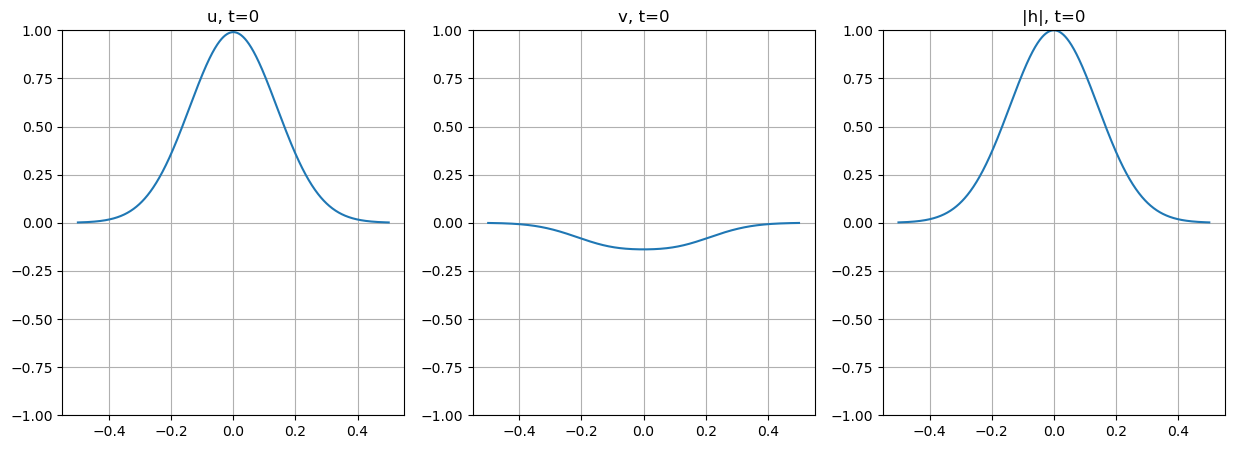

In [5]:
u0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))
v0_fn = lambda x, t: jnp.exp(-25*x**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*x)))

u0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.cos(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))
v0_fn_ = lambda xt: jnp.exp(-25*xt[0]**2)*jnp.sin(-0.2/epsilon*jnp.log(2*jnp.cosh(5*xt[0])))

du0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 1:2]
dv0_dt_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 1:2]

du0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(u0_fn_), in_axes = 0)(xt)[:, 0:1]
dv0_dx_fn = lambda xt: jax.vmap(jax.jacfwd(v0_fn_), in_axes = 0)(xt)[:, 0:1]

du0_dxx_fn = lambda xt: jax.vmap(jax.hessian(u0_fn_), in_axes = 0)(xt)[:, 0, 0:1]
dv0_dxx_fn = lambda xt: jax.vmap(jax.hessian(v0_fn_), in_axes = 0)(xt)[:, 0, 0:1]

x0 = np.linspace(*domain[:, 0], 1000)
t0 = np.zeros_like(x0)
u0 = u0_fn(x0, t0)
v0 = v0_fn(x0, t0)

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

f, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].plot(x0, u0)
ax[0].set_title("u, t=0")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[1].plot(x0, v0)
ax[1].set_title("v, t=0")
ax[1].grid()
ax[1].set_ylim([-1, 1])
ax[2].plot(x0, np.sqrt(u0**2+v0**2))
ax[2].set_title("|h|, t=0")
ax[2].grid()
ax[2].set_ylim([-1, 1])
plt.show()

key, *subkeys = random.split(key, 3)

n_i = 2048
# x_i = random.uniform(subkeys[0], (n_i, 1), jnp.float32, *domain[:, 0])
x_i = jnp.linspace(*domain[:, 0], n_i).reshape((-1, 1))
t_i = jnp.zeros_like(x_i)
u_i = u0_fn(x_i, t_i)
v_i = v0_fn(x_i, t_i)
du_dxx_i = du0_dxx_fn(jnp.hstack([x_i, t_i]))
dv_dxx_i = dv0_dxx_fn(jnp.hstack([x_i, t_i]))
du_dt_i = 1.0/epsilon*(V*v_i - 1/2*epsilon**2*dv_dxx_i)
dv_dt_i = 1.0/epsilon*(1/2*epsilon**2*du_dxx_i - V*u_i)
du_dx_i = du0_dx_fn(jnp.hstack([x_i, t_i]))
dv_dx_i = dv0_dx_fn(jnp.hstack([x_i, t_i]))

n_cx = 1024
n_ct = 501
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
xt_c = tensor_grid([x_c, t_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "u", "v"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t"])
dataset_Neumann = namedtuple("dataset_Neumann", ["x", "t", "du_dt", "dv_dt", "du_dx", "dv_dx", "du_dxx", "dv_dxx"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t"])

dirichlet = dataset_Dirichlet(x_i, t_i, u_i, v_i)
collocation = dataset_Collocation(xt_c[:, 0:1], xt_c[:, 1:2])
neumann = dataset_Neumann(x_i, t_i, du_dt_i, dv_dt_i, du_dx_i, dv_dx_i, du_dxx_i, dv_dxx_i)

In [6]:
class Time_Marching_Generator:
	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
		self.key = key
		self.spatial_points = spatial_points
		self.domain = temporal_domain
		self.batch_size = batch_size
		self.iterations = iterations
		self._count1 = count1
		self._count2 = update_every
		if count1 < iterations:
			self._update(self.domain[0])
		else:
			self._update(self.domain[1])
		self.update_every = update_every
		
	def _update(self, tmax):
		self.key, subkey = random.split(self.key)
		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self._count2 == self.update_every:
			self._count1 = max(self.iterations, self._count1 + 1)
			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
			self._update(tmax)
			self._count2 = 0
		else:
			self._count2 += 1
		return self.spatial_points, self._t

In [7]:
# pre-train, no bc

lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 100, "collocation": 20000, "neumann": 100}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Neumann = Batch_Generator(subkeys[1], neumann, batch_size["neumann"])
Collocation = Batch_Generator(subkeys[2], collocation, batch_size["collocation"])

start_iteration = 0
iterations = 100000
print_every = 500
save_every = 10000
weights = {"c": 1.0, "d": 10.0, "nt": 1.0, "nx": 1.0, "nxx": 1.0, "l1": 1e-6, "l2": 1e-6}

for iteration in range(start_iteration, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"neumann": dataset_Neumann(*next(Neumann)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d", "nt", "nx", "nxx", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"neumann": dataset_Neumann(*Neumann.dataset),
			"collocation": batch["collocation"],
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/21, 19:27:32, Iteration: 0, Train Loss: 6.7618e+02, c: 2.0813e+02, d: 1.5633e+00, nt: 2.6483e+01, nx: 1.4114e+01, nxx: 4.1182e+02, l1_reg: 4.9429e+03, l2_reg: 5.3145e+03
2020/08/21, 19:28:11, Iteration: 500, Train Loss: 1.0154e+01, c: 3.3148e+00, d: 2.2272e-02, nt: 1.1144e+00, nx: 2.3500e-01, nxx: 5.2666e+00, l1_reg: 4.8745e+03, l2_reg: 5.2564e+03
2020/08/21, 19:28:39, Iteration: 1000, Train Loss: 5.7419e+00, c: 1.9257e+00, d: 1.5323e-02, nt: 5.2580e-01, nx: 1.5744e-01, nxx: 2.9798e+00, l1_reg: 4.8558e+03, l2_reg: 5.2397e+03
2020/08/21, 19:28:58, Iteration: 1500, Train Loss: 4.9112e+00, c: 1.5788e+00, d: 1.9622e-02, nt: 5.0470e-01, nx: 1.5558e-01, nxx: 2.4759e+00, l1_reg: 4.8423e+03, l2_reg: 5.2297e+03
2020/08/21, 19:29:17, Iteration: 2000, Train Loss: 4.8623e+00, c: 1.4038e+00, d: 2.5941e-02, nt: 6.7752e-01, nx: 1.9908e-01, nxx: 2.3225e+00, l1_reg: 4.8309e+03, l2_reg: 5.2229e+03
2020/08/21, 19:29:35, Iteration: 2500, Train Loss: 4.4904e+00, c: 1.2549e+00, d: 1.7782e-02, nt: 8.

2020/08/21, 19:42:35, Iteration: 23000, Train Loss: 1.3706e+00, c: 4.2150e-01, d: 7.1029e-03, nt: 2.9886e-01, nx: 5.8927e-02, nxx: 5.2025e-01, l1_reg: 4.5952e+03, l2_reg: 5.2390e+03
2020/08/21, 19:42:54, Iteration: 23500, Train Loss: 1.2741e+00, c: 3.9966e-01, d: 1.0550e-02, nt: 2.2558e-01, nx: 6.7249e-02, nxx: 4.7612e-01, l1_reg: 4.5923e+03, l2_reg: 5.2403e+03
2020/08/21, 19:43:12, Iteration: 24000, Train Loss: 1.2464e+00, c: 3.9846e-01, d: 8.3306e-03, nt: 3.0732e-01, nx: 5.0320e-02, nxx: 4.0702e-01, l1_reg: 4.5890e+03, l2_reg: 5.2414e+03
2020/08/21, 19:43:32, Iteration: 24500, Train Loss: 1.0697e+00, c: 3.9627e-01, d: 3.8320e-03, nt: 2.0299e-01, nx: 4.1146e-02, nxx: 3.9093e-01, l1_reg: 4.5856e+03, l2_reg: 5.2425e+03
2020/08/21, 19:43:50, Iteration: 25000, Train Loss: 1.3418e+00, c: 4.0438e-01, d: 8.7596e-03, nt: 1.8607e-01, nx: 6.0890e-02, nxx: 6.0290e-01, l1_reg: 4.5829e+03, l2_reg: 5.2436e+03
2020/08/21, 19:44:09, Iteration: 25500, Train Loss: 1.4725e+00, c: 4.3783e-01, d: 1.2568e-

2020/08/21, 20:00:35, Iteration: 51500, Train Loss: 1.1359e+00, c: 3.6933e-01, d: 9.9802e-03, nt: 1.5611e-01, nx: 5.3243e-02, nxx: 4.5737e-01, l1_reg: 4.4255e+03, l2_reg: 5.2978e+03
2020/08/21, 20:00:54, Iteration: 52000, Train Loss: 1.3318e+00, c: 3.3575e-01, d: 5.5110e-03, nt: 2.2839e-01, nx: 5.8704e-02, nxx: 6.5384e-01, l1_reg: 4.4229e+03, l2_reg: 5.2985e+03
2020/08/21, 20:01:13, Iteration: 52500, Train Loss: 1.0454e+00, c: 3.4269e-01, d: 6.3961e-03, nt: 2.0815e-01, nx: 4.1149e-02, nxx: 3.8941e-01, l1_reg: 4.4201e+03, l2_reg: 5.2996e+03
2020/08/21, 20:01:32, Iteration: 53000, Train Loss: 9.5869e-01, c: 3.0555e-01, d: 5.5937e-03, nt: 2.5584e-01, nx: 4.5143e-02, nxx: 2.9622e-01, l1_reg: 4.4180e+03, l2_reg: 5.3006e+03
2020/08/21, 20:01:51, Iteration: 53500, Train Loss: 1.3069e+00, c: 3.5324e-01, d: 6.8527e-03, nt: 1.8747e-01, nx: 6.2602e-02, nxx: 6.3510e-01, l1_reg: 4.4155e+03, l2_reg: 5.3015e+03
2020/08/21, 20:02:10, Iteration: 54000, Train Loss: 1.3174e+00, c: 3.0972e-01, d: 6.4808e-

2020/08/21, 20:15:06, Iteration: 74500, Train Loss: 9.7535e-01, c: 3.0370e-01, d: 8.5178e-03, nt: 2.6457e-01, nx: 4.1435e-02, nxx: 2.8047e-01, l1_reg: 4.3179e+03, l2_reg: 5.3355e+03
2020/08/21, 20:15:25, Iteration: 75000, Train Loss: 8.8668e-01, c: 2.8291e-01, d: 8.2695e-03, nt: 1.6586e-01, nx: 5.5599e-02, nxx: 2.9962e-01, l1_reg: 4.3153e+03, l2_reg: 5.3362e+03
2020/08/21, 20:15:44, Iteration: 75500, Train Loss: 1.0069e+00, c: 3.0256e-01, d: 4.9767e-03, nt: 2.4310e-01, nx: 3.9800e-02, nxx: 3.7171e-01, l1_reg: 4.3136e+03, l2_reg: 5.3372e+03
2020/08/21, 20:16:02, Iteration: 76000, Train Loss: 1.0116e+00, c: 2.6574e-01, d: 8.4934e-03, nt: 1.5693e-01, nx: 4.9765e-02, nxx: 4.5424e-01, l1_reg: 4.3116e+03, l2_reg: 5.3381e+03
2020/08/21, 20:16:22, Iteration: 76500, Train Loss: 8.4722e-01, c: 2.6982e-01, d: 6.0480e-03, nt: 2.1655e-01, nx: 3.8516e-02, nxx: 2.6186e-01, l1_reg: 4.3095e+03, l2_reg: 5.3389e+03
2020/08/21, 20:16:40, Iteration: 77000, Train Loss: 1.0827e+00, c: 3.2159e-01, d: 1.2471e-

2020/08/21, 20:29:39, Iteration: 97500, Train Loss: 1.1523e+00, c: 2.6869e-01, d: 7.1542e-03, nt: 3.8686e-01, nx: 3.8683e-02, nxx: 3.8650e-01, l1_reg: 4.2283e+03, l2_reg: 5.3648e+03
2020/08/21, 20:29:58, Iteration: 98000, Train Loss: 8.7140e-01, c: 2.2447e-01, d: 5.0157e-03, nt: 2.1580e-01, nx: 4.0155e-02, nxx: 3.4082e-01, l1_reg: 4.2261e+03, l2_reg: 5.3650e+03
2020/08/21, 20:30:17, Iteration: 98500, Train Loss: 8.7296e-01, c: 2.6885e-01, d: 6.6059e-03, nt: 2.0812e-01, nx: 3.4488e-02, nxx: 2.9545e-01, l1_reg: 4.2245e+03, l2_reg: 5.3656e+03
2020/08/21, 20:30:36, Iteration: 99000, Train Loss: 6.9830e-01, c: 2.2859e-01, d: 6.3953e-03, nt: 9.5887e-02, nx: 3.7672e-02, nxx: 2.7220e-01, l1_reg: 4.2225e+03, l2_reg: 5.3660e+03
2020/08/21, 20:30:54, Iteration: 99500, Train Loss: 8.9017e-01, c: 2.3126e-01, d: 6.4544e-03, nt: 2.9672e-01, nx: 4.6178e-02, nxx: 2.5147e-01, l1_reg: 4.2211e+03, l2_reg: 5.3666e+03
2020/08/21, 20:31:13, Iteration: 100000, Train Loss: 7.6669e-01, c: 2.7506e-01, d: 6.8984e

In [ ]:
x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
t = jnp.zeros_like(x)
xt = jnp.hstack([x, t])


# direct_params_ = direct_params
direct_params_ = get_params(opt_state)
duv_dxt = jacobian(direct_params_, xt)
du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
duv_dxxtt = hessian(direct_params_, xt)
du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
uv = model(direct_params_, xt)
u, v = uv[:, 0:1], uv[:, 1:2]
loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

%matplotlib inline
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["text.usetex"] = True

f, ax = plt.subplots(2, 5, figsize = (20, 10))
i, j = 0, 0
ax[i][j].plot(x, du_dt, label = "pred")
ax[i][j].plot(x, du0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
i = 1
ax[i][j].plot(x, dv_dt, label = "pred")
ax[i][j].plot(x, dv0_dt, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dx, label = "pred")
ax[i][j].plot(x, du0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
i = 1
ax[i][j].plot(x, dv_dx, label = "pred")
ax[i][j].plot(x, dv0_dx, label = "true")
ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
i, j = 0, j+1
ax[i][j].plot(x, du_dxx, label = "pred")
ax[i][j].plot(x, du0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
i = 1
ax[i][j].plot(x, dv_dxx, label = "pred")
ax[i][j].plot(x, dv0_dxx, label = "true")
ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
i, j = 0, j+1
ax[i][j].plot(x, u, label = "pred")
ax[i][j].plot(x, u0, label = "true")
ax[i][j].set_title(r"$u$")
i = 1
ax[i][j].plot(x, v, label = "pred")
ax[i][j].plot(x, v0, label = "true")
ax[i][j].set_title(r"$v$")
i, j = 0, j+1
ax[i][j].plot(x, loss_c1, label = "pred")
ax[i][j].plot(x, loss_c10, label = "true")
ax[i][j].set_title(r"loss c1")
i = 1
ax[i][j].plot(x, loss_c2, label = "pred")
ax[i][j].plot(x, loss_c20, label = "true")
ax[i][j].set_title(r"loss c2")

for i in range(2):
	for j in range(5):
		ax[i][j].legend()
		ax[i][j].grid()
plt.show()

In [ ]:
from scipy.io import loadmat

uv_true = loadmat("ex1_extended_epsilon_1.0.mat")["u"].T

from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 3, figsize = (15, 5))
lines = []
for i in range(3):
    line1, = ax[i].plot([], [], lw = 1.5, label = "true")
    line2, = ax[i].plot([], [], lw = 1.5, label = "pred")
    lines.extend([line1, line2])
    ax[i].set_xlim([-0.5, 0.5])
    ax[i].set_ylim([-1, 1])
    ax[i].legend()
    ax[i].grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 1024)
t_test = jnp.linspace(*domain[:, 1], 501)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]
uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]

def animate(i):
	u_pred, v_pred = u_preds[i], v_preds[i]
	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
	lines[0].set_data(x_test, u_true)
	lines[1].set_data(x_test, u_pred)
	ax[0].set_title("u, t = {:.2f}".format(t_test[i]))
    
	lines[2].set_data(x_test, v_true)
	lines[3].set_data(x_test, v_pred)
	ax[1].set_title("v, t = {:.2f}".format(t_test[i]))

	lines[4].set_data(x_test, np.sqrt(u_true**2+v_true**2))
	lines[5].set_data(x_test, np.sqrt(u_pred**2+v_pred**2))
	ax[2].set_title("|h|, t = {:.2f}".format(t_test[i]))

	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()